# Notes on Automatic Differentiation Variational Inference

Alp Kucukelbir, Dustin Tran, Rajesh Ranganath, Andrew Gelman, David M. Blei

http://arxiv.org/abs/1603.00788

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import scipy.stats
%matplotlib inline

## Variational Inference

__What we want:__

* the posterior distribution, or an estimate thereof, for some model over some dataset

__What we have:__

* a dataset $x_{1:N}$ of $N$ observations
* a model, generally containing latent variables $\theta$
* (the model is often expressed as a probabilistic graphical model with likelihood $p(x \mid \theta)$ and prior $p(\theta)$)
* so we then have the join probability distribution $p(x, \theta) = p\left(x\mid\theta\right)p(\theta)$

__Challenges:__

* non-conjugate models (can be complex or no closed-form solutions)
* MCMC can be slow, or some samplers may not converge for some models

__A way to proceed:__

* find a distribution that is approximates the posterior
* find a cost function that represents how close the approximate distribution is from the posterior
* minimize that cost function

__Some constraints:__

* only consider differentiable models

### K-L divergence (the 'cost function')

https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence

Continuous divergence

$$D_{\mathrm KL}(q \mid\mid p)  = \int_{\theta} q(\theta) \log\frac{q(\theta)}{p(\theta\mid x)}
            = \mathbb{E}_q \left[ \log \frac{q(\theta)}{p(\theta \mid x)} \right] \geq 0,
$$

between an approximate distribution $q$ and the posterior $p(\theta \mid x)$.
* not symmetric in exchange between $q$ and $p$
* kindof like a distance function between distributions, but not a true metric
* Bishop, 2006 gives a discussion by VI approaches generally use $D_{\mathrm KL}(q \mid\mid p)$ instead of $D_{\mathrm KL}(p \mid\mid q)$

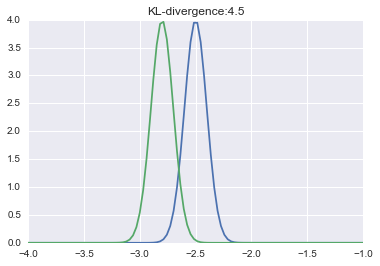

In [3]:
t1 = scipy.stats.norm(-2.5, 0.1)
t2 = scipy.stats.norm(-2.8, 0.1)

x = np.linspace(-4,-1,100)

plt.plot(x,t1.pdf(x))
plt.plot(x,t2.pdf(x))
plt.title("KL-divergence:" + str(scipy.stats.entropy(t1.pdf(x), t2.pdf(x))));

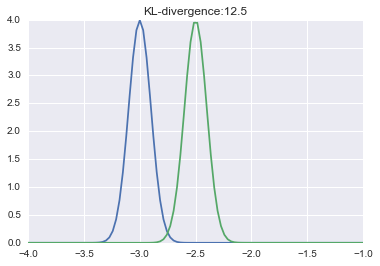

In [4]:
t3 = scipy.stats.norm(-3, 0.1)
t4 = scipy.stats.norm(-2.5, 0.1)

x = np.linspace(-4,-1,100)

plt.plot(x,t3.pdf(x))
plt.plot(x,t4.pdf(x))
plt.title("KL-divergence:" + str(scipy.stats.entropy(t3.pdf(x), t4.pdf(x))));

### ELBO

* We want to minimize the KL divergence, but since it explicitly includes the posterior, we need a proxy measure that approximates the divergence. For this, we'll use the Evidence Lower BOund (ELBO):

$$
\begin{align}
    \log p(x) &= \log\int_{\theta} p(x,\theta) \\
              &= \log\int_{\theta} p(x,\theta) \frac{q(\theta)}{q(\theta)} \\
              &= \log\left(\mathbb{E}_q\left[ \frac{p(x,\theta)}{q(\theta)} \right]\right) \\
              & \left. \geq \mathbb{E}_q[\log p(x,\theta)] - \mathbb{E}_q[\log q(\theta)] = \mathrm{ELBO} = \mathcal{L} \right.
\end{align}
$$

which can be related to the KL divergence:

$$
\begin{align}
    D_{\mathrm KL}(q \mid\mid p) &= \mathbb{E}_q \left[ 
        \log \frac{q(\theta)}{p(\theta \mid x)} 
    \right] \\
        &= \mathbb{E}_q \left[ \log \frac{q(\theta)}{p(\theta,x)/p(x)} \right] \\
        &= \mathbb{E}_q \left[\log q(\theta)\right] 
          -\mathbb{E}_q \left[\log p(\theta,x)\right]
          + \log p(x) \\
        &= -(\mathrm{ELBO}) + \log p(x) \\
        &= -\mathcal{L} + \log p(x)
\end{align}
$$

* Since $D_{\mathrm KL}(q \mid\mid p) \geq 0$ and $\log p(x) = \mathrm{constant}$, maximizing the ELBO minimizes the KL divergence. As such, finding a good approximate posterior comes down to finding a good $q$, as well as a optimization problem to maximize the corresponding ELBO.

### The importance of support-matching

* The gradient $\nabla_{\theta} \log p(x,\theta)$ is valid within the support of the prior:

$$
    \mathrm{supp}(p(\theta)) = \left\{
        \theta \mid \theta \in \mathbb{R}^{K} \,\mathrm{and}\, p(\theta)>0 
    \right\}
    \subseteq \mathbb{R}^{K},
$$

where $K$ is the dimension of the latent variable space.

* This is due to the fact that if 

$$
    \mathrm{supp}(q) \subsetneq \mathrm{supp}(p) 
        \implies 
    D_{\mathrm KL}(q \mid\mid p) = \mathbb{E}_{q}[\log q] - \mathbb{E}_{p}[\log p] = -\infty
$$

## ADVI

### Transformation to unbounded real coordinate space

* Need to ensure that the support of the prior is unbounded, so we don't have to worry about mis-matched support
* introduce a coordinate transformation, $T : \mathrm{supp}(p(\theta)) \rightarrow \mathbb{R}^{K}$, that maps the latent coordinates to the unbounded real space
* variables in this mapped space are $\zeta = T(\theta)$

$$
    p(x, \zeta) = p\left( x, T^{-1}(\theta) \right)
    \left| 
        \det J_{T^{-1}} (\zeta)
    \right|
$$

* the Jacobian ensures that the transformed density integrates to one

### Mean-field Gaussian

* one approach is to try a factorized Gaussian solution in the real-valued coordinate space

$$
    q(\zeta, \phi) = \mathcal{N}(\zeta; \mu, \mathrm{diag}(\sigma^2))
    = \prod_{k=1}^{K} \mathcal{N}(\zeta_k; \mu_k, \sigma_k^2)
$$

where $\phi = (\mu_1, \dots, \mu_K, \sigma_1^2, \dots, \sigma_K^2)$

* however, these parameters live in the set of $\Phi = \left\{ \mathbb{R}^{K}, \mathbb{R}^{K}_{\gt 0} \right\}$
* reparameterize as $\omega = \log(\sigma)$, then

$$
    q(\zeta, \phi) = \mathcal{N}\left(\zeta; \mu, \mathrm{diag}(\exp(\omega)^2)\right)
$$

* where the parameters $\phi = (\mu_1, \dots, \mu_K, \omega_1, \dots, \omega_K)$ are unconstrained in $\mathbb{R}^{2K}$

### Full-rank Gaussian

* another approach is to use a full-rank Gaussian,

$$
    q(\zeta; \phi) = \mathcal{N}(\zeta; \mu, \Sigma)
$$

where $\phi = (\mu, \Sigma)$ are the mean values, $\mu$, and the covariance matrix $\Sigma$

* to ensure that $\Sigma$ is positive semidefinite, it can be reparameterize as $\Sigma = LL^{T}$, using the non-unique definition of the Cholesky factorization, such that $L$ is in the unconstrained space of lower-triangle matrices with $K(K + 1)/2$ real-valued entries. So then

$$
    q(\zeta; \phi) = \mathcal{N}(\zeta; \mu, L L^{T})
$$

where $\phi = (\mu, L)$ are unconstrained in $\mathbb{R}^{K + K(K+1)/2}$

* the full-rank Gaussian is a generalization of the mean-field approximation, and the off-diagonal terms in the covariance matrix capture correlations in the posterior distribution
* however, it is computationally more costly to compute

### Variation inference in the real-coodinate space

* after employing the transformation function, the ELBO becomes

$$
    \mathcal{L}(\phi) = 
    \mathbb{E}_{q(\zeta;\phi)} \left[
        \log p \left(
            x, T^{-1}(\zeta)
        \right)
        +
        \log \left| 
            \det J_{T^{-1}} (\zeta)
        \right|
    \right]
    +
    \mathbb{H} \left[
        q(\zeta; \phi)
    \right]
$$

where $\mathbb{H}$ is the entropy

* the ELBO can then be optimized with respect to the variational parameters $\phi$ without worrying about the constraining the support:

$$
    \phi^{*} = {\arg\max}_{\phi} \mathcal{L}(\phi)
$$

* which can be tackled via gradient ascent:

$$
    \begin{align}
        \mu^{(i+1)} &\leftarrow \mu^{(i)} + \alpha \nabla_{\mu} \mathcal{L}, \\
        \omega^{(i+1)} &\leftarrow \omega^{(i)} + \alpha \nabla_{\omega} \mathcal{L},
            & \mathrm{(mean \, field)} \\
        L^{(i+1)} &\leftarrow L^{(i)} + \alpha \nabla_{L} \mathcal{L},
            & \mathrm{(full \, rank)}
    \end{align}
$$

where $\nabla \mathcal{L}$ is the gradient of the ELBO.

### ELBO gradients

* we would like to compute the gradients of the ELBO using automatic differentiation methods, but the ELBO has the unknown expectation $\mathbb{E}_{q(\zeta;\phi)}$
* to proceed, we'll apply another transformation that will ultimately allow us to take the gradients inside the expectation
* specifically, the transformation $S_{\phi}$ absorbs the variational parameters $\phi$, and converts the variational approximation Gaussian into a standard Gaussian

$$
\begin{align}
    \eta = S_{\phi}(\zeta) &= \mathrm{diag}(\exp(\omega)^2)^{-1} (\zeta - \mu)
        & \mathrm{(mean \, field)} \\
    \eta = S_{\phi}(\zeta) &= L^{-1} (\zeta - \mu) 
        & \mathrm{(full \, rank)}
\end{align}
$$

The variational density then becomes:
$$
    q(\eta) = \mathcal{N}(\eta; 0, I) = \prod_{k=1}^{K} \mathcal{N}(\eta_k; 0, I),
$$

and the optimization problem becomes:

$$
    \phi^{*} = \arg\max_{\phi}
    \mathbb{E}_{\mathcal{N}(\eta; 0, I)} \left[
        \log p \left(
            x, T^{-1}\left(S_{\phi}^{-1}(\eta)\right)
        \right)
        +
        \log \left| 
            \det J_{T^{-1}} \left(S_{\phi}^{-1}(\eta)\right)
        \right|
    \right]
    +
    \mathbb{H} \left[
        q(\zeta; \phi)
    \right]
$$

* since the expectation no longer depends on $\phi$, we can push the gradient inside of the expectation:

$$
    \nabla_{\mu} \mathcal{L} = 
    \mathbb{E}_{\mathcal{N}(\eta)} \left[
        \nabla_{\theta} \log p(x, \theta)
        \nabla_{\zeta} T^{-1}(\zeta)
        +
        \nabla_{\zeta} \log \left|
            \det J_{T^{-1}}(\zeta)
        \right|
    \right]
$$

and

$$
\begin{align}
    \nabla_{\omega} \mathcal{L} &= 
    \mathbb{E}_{\mathcal{N}(\eta)} \left[
        \left(        
            \nabla_{\theta} \log p(x, \theta)
            \nabla_{\zeta} T^{-1}(\zeta)
            +
            \nabla_{\zeta} \log \left|
                \det J_{T^{-1}}(\zeta)
            \right|
        \right)
        \eta^{T} \mathrm{diag}(\exp(\omega))
    \right]
    + 1         & \mathrm{(mean \, field)} \\
    \nabla_{L} \mathcal{L} &= 
    \mathbb{E}_{\mathcal{N}(\eta)} \left[
        \left(        
            \nabla_{\theta} \log p(x, \theta)
            \nabla_{\zeta} T^{-1}(\zeta)
            +
            \nabla_{\zeta} \log \left|
                \det J_{T^{-1}}(\zeta)
            \right|
        \right)
        \eta^{T}
    \right]
    +
    (L^{-1})^{T} & \mathrm{(full \, rank)} \\
\end{align}
$$

* the gradients inside the expectation can now be computed using automatic differentiation
* the expectation itself can be estimated using MC integration
* that is, we can sample from the standard Gaussian and evaluate the emperical mean of the gradients in within the expectation
* this procedure gives noisy unbiased gradients of the ELBO of any differentiable probability model, and we can further use those gradients for a stochastic optimization for the variational inference

### Stochastic gradient ascent

* armed with the noisy gradients, the optimization of the ELBO can proceed via the gradient ascent approach discussed above
* the stepsize, $\alpha$ can be made to be made to vary, and a procedure outlined in the paper discusses the calculation of the stepsize at each iteration

### Complexity

* ADVI has complexity $\vartheta(NMK)$ per iteration, where $N$ is the number of datapoints, $M$ is the number of MC samples, and $K$ is the number of latent variables
* scaling to large datasets can be done by subsampling. For a minibatch of size $B \ll N$, the complexity per iteration is $\vartheta(BMK)$

## Examples

Generate a small dataset dataset with fixed probability `p=0.2` of an entry being a 1:

In [4]:
data = np.random.binomial(1, 0.2, size=20)
print data

[0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0]


We'll make a simple, but not trivial, model to try out the ADVI methods in `pymc3` and `Stan`.

## pymc3

I think `pymc3` currently only supports the Mean-Field version of ADVI.

In [5]:
import pymc3 as pm

Couldn't import dot_parser, loading of dot files will not be possible.


In [6]:
with pm.Model() as model:
    alpha = pm.HalfCauchy('alpha', 20)
    beta  = pm.HalfCauchy('beta', 50)
    
    prior = pm.Beta('p', alpha=alpha, beta=beta)
    likelihood = pm.Binomial('binomial', n=len(data), p=prior, observed=sum(data))

Applied log-transform to alpha and added transformed alpha_log to model.
Applied log-transform to beta and added transformed beta_log to model.
Applied logodds-transform to p and added transformed p_logodds to model.


For `pymc3`, `accurate_elbo=False` means that the number of MC samples per iteration is set to $M=1$:

In [7]:
%%time
advi_fit = pm.variational.advi(model=model, n=4000, accurate_elbo=False)

Iteration 0 [0%]: ELBO = -3.9
Iteration 400 [10%]: Average ELBO = -28.8
Iteration 800 [20%]: Average ELBO = -24.09
Iteration 1200 [30%]: Average ELBO = -20.25
Iteration 1600 [40%]: Average ELBO = -18.58
Iteration 2000 [50%]: Average ELBO = -17.92
Iteration 2400 [60%]: Average ELBO = -15.24
Iteration 2800 [70%]: Average ELBO = -12.94
Iteration 3200 [80%]: Average ELBO = -11.75
Iteration 3600 [90%]: Average ELBO = -10.62
Finished [100%]: Average ELBO = -10.56
CPU times: user 3.51 s, sys: 369 ms, total: 3.88 s
Wall time: 10.8 s


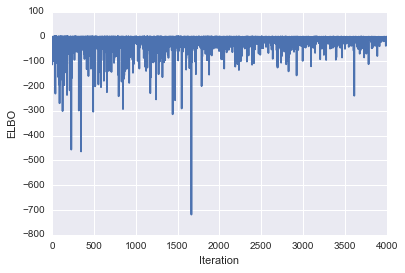

In [8]:
plt.plot(advi_fit.elbo_vals)
plt.xlabel('Iteration')
plt.ylabel("ELBO");

In [9]:
print advi_fit

ADVIFit(means={'alpha_log_': array(2.7251985780730963), 'beta_log_': array(3.750899891216531), 'p_logodds_': array(-1.0869779295409336)}, stds={'alpha_log_': 0.61737582209059227, 'beta_log_': 0.64250377477510057, 'p_logodds_': 0.57563120930079181}, elbo_vals=array([ -3.90476844,  -2.82537291, -42.19240793, ..., -11.15347832,
        -3.4346194 ,  -4.77228724]))


On the other hand, with `accurate_elbo=True`, $M=100$:

In [10]:
%%time
advi_fit = pm.variational.advi(model=model, n=4000, accurate_elbo=True)

Iteration 0 [0%]: ELBO = -35.23
Iteration 400 [10%]: Average ELBO = -26.89
Iteration 800 [20%]: Average ELBO = -18.48
Iteration 1200 [30%]: Average ELBO = -12.9
Iteration 1600 [40%]: Average ELBO = -9.64
Iteration 2000 [50%]: Average ELBO = -7.33
Iteration 2400 [60%]: Average ELBO = -5.98
Iteration 2800 [70%]: Average ELBO = -5.18
Iteration 3200 [80%]: Average ELBO = -4.76
Iteration 3600 [90%]: Average ELBO = -4.58
Finished [100%]: Average ELBO = -4.53
CPU times: user 25.3 s, sys: 576 ms, total: 25.9 s
Wall time: 33.1 s


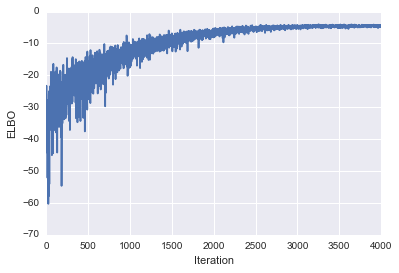

In [11]:
plt.plot(advi_fit.elbo_vals)
plt.xlabel('Iteration')
plt.ylabel("ELBO");

In [12]:
print advi_fit

ADVIFit(means={'alpha_log_': array(2.0496932971415927), 'beta_log_': array(3.6787438305091418), 'p_logodds_': array(-1.6862302056890575)}, stds={'alpha_log_': 0.35386626709018154, 'beta_log_': 0.3674171620327436, 'p_logodds_': 0.33450676412542907}, elbo_vals=array([-35.22716538, -23.25196236, -37.7726848 , ...,  -4.28355296,
        -4.70956574,  -4.35644914]))


To get a good look at the approximate posterior, we can use the `sample_vp` function, which draws Gaussian samples in the real-space, then transforms the samples back to latent variable space:

In [13]:
advi_trace = pm.variational.sample_vp(advi_fit, draws=5000, model=model)

Compare with the NUTS sampler:

In [14]:
with model:
    step = pm.NUTS()
    nuts_trace = pm.sample(5000, step)

 [-----------------100%-----------------] 5000 of 5000 complete in 14.9 sec

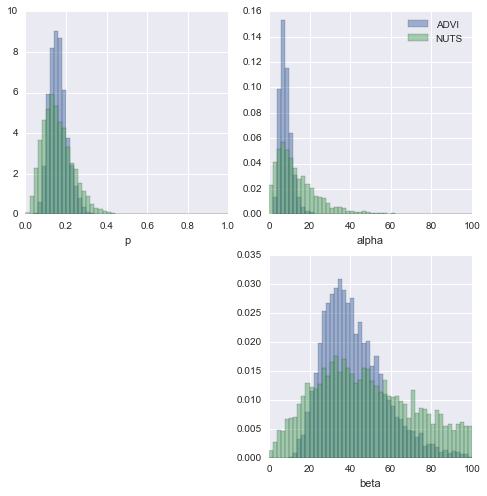

In [61]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)

plt.hist(advi_trace['p'], range=[0,1], bins=50, normed=True, label='ADVI', alpha=0.5)
plt.hist(nuts_trace['p'], range=[0,1], bins=50, normed=True, label='NUTS', alpha=0.5)
plt.xlabel("p")

plt.subplot(2,2,2)
plt.hist(advi_trace['alpha'], range=[0,100], bins=50, normed=True, label='ADVI', alpha=0.5)
plt.hist(nuts_trace['alpha'], range=[0,100], bins=50, normed=True, label='NUTS', alpha=0.5)
plt.xlabel("alpha")
plt.legend()

plt.subplot(2,2,4)
plt.hist(advi_trace['beta'], range=[0,100], bins=50, normed=True, label='ADVI', alpha=0.5)
plt.hist(nuts_trace['beta'], range=[0,100], bins=50, normed=True, label='NUTS', alpha=0.5)
plt.xlabel("beta");

### pystan

In [24]:
from pystan import StanModel, stan

In [38]:
model_code = """
    data {
        int<lower=0> N;
        int<lower=0,upper=1> y[N];
    }
    parameters {
        real<lower=0> alpha;
        real<lower=0> beta;
        real<lower=0, upper=1> p;
    }
    model {
        alpha ~ cauchy(0, 20);
        beta ~ cauchy(0, 50);
        p ~ beta(alpha, beta);
        for (n in 1:N)
            y[n] ~ bernoulli(p);
    }
"""

stan_data = {
    'N':len(data),
    'y':data
}

### pystan NUTS

Again, for comparison

In [39]:
stan_nuts = stan(model_code=model_code, data=stan_data)

In [51]:
print stan_nuts

Inference for Stan model: anon_model_2df7ffd52b91f10700e84d4a94d52b93.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha  33.27   11.63  47.95   1.84   7.87  15.29  30.69 190.23   17.0   1.22
beta  176.84   36.37 241.25  12.47  43.91  84.18 182.95  895.4   44.0   1.09
p       0.16  3.9e-3   0.07   0.04   0.11   0.15   0.21   0.33  370.0   1.02
lp__   -4.51    0.08   1.37  -7.95  -5.29  -4.23  -3.45  -2.82  279.0   1.01

Samples were drawn using NUTS at Wed Jul 13 10:46:45 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


### pystan Mean-field

Note: although Stan's ADVI feature has been around for a couple months, the PyStan integration for ADVI was pushed literally yesterday, so no guarantees on the bleeding edge.

In [45]:
stan_model = StanModel(model_code=model_code)

In [46]:
results = stan_model.vb(data=stan_data, iter=10000, output_samples=10000, algorithm='meanfield')
print(results)

OrderedDict([('args', {'algorithm': 'MEANFIELD', 'random_seed': '89366828', 'tol_rel_obj': 0.01, 'eval_elbo': 100, 'sample_file': '/var/folders/ks/ny8mvlt11hbfnk6vcdd8ghx4b6qs2l/T/tmpYzZ6_3/output.csv', 'output_samples': 10000, 'init_radius': 2.0, 'chain_id': 1, 'iter': 10000, 'adapt_engaged': True, 'init': 'random', 'eta': 1.0, 'grad_samples': 1, 'elbo_samples': 100, 'append_samples': False, 'enable_random_init': False, 'method': 'VARIATIONAL', 'adapt_iter': 50}), ('mean_pars', [])])


The model samples are currently being written to disk, so we'll import them back in:

In [47]:
meanfield_samples = pd.read_csv(
    results['args']['sample_file'],
    skiprows=7,
    names=['alpha','beta','p']
)

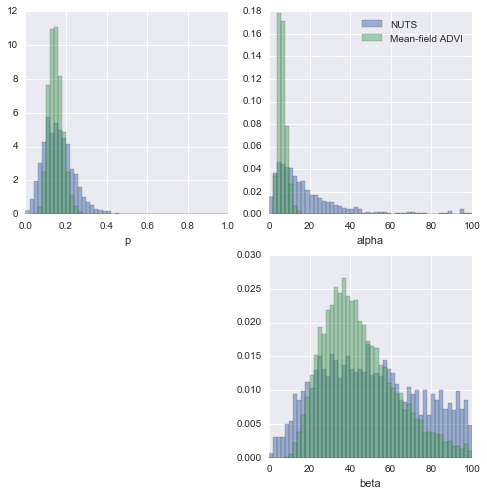

In [60]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)

plt.hist(stan_nuts['p'], range=[0,1], bins=50, normed=True, label='NUTS', alpha=0.5)
plt.hist(meanfield_samples['p'].values, range=[0,1], bins=50,
         normed=True, label='Mean-field ADVI', alpha=0.5)
plt.xlabel("p")

plt.subplot(2,2,2)
plt.hist(stan_nuts['alpha'], range=[0,100], bins=50, normed=True, label='NUTS', alpha=0.5)
plt.hist(meanfield_samples['alpha'], range=[0,100], bins=50,
         normed=True, label='Mean-field ADVI', alpha=0.5)
plt.xlabel("alpha")
plt.legend()

plt.subplot(2,2,4)
plt.hist(stan_nuts['beta'], range=[0,100], bins=50, normed=True, label='NUTS', alpha=0.5)
plt.hist(meanfield_samples['beta'].values, range=[0,100], bins=50,
         normed=True, label='Mean-field ADVI', alpha=0.5)
plt.xlabel("beta");

### pystan Full-rank

We can also look at the output of the Full-Rank flavour of ADVI:

In [52]:
fullrank_results = stan_model.vb(data=stan_data, iter=10000,
                                 output_samples=10000, algorithm='fullrank')
print fullrank_results

OrderedDict([('args', {'algorithm': 'FULLRANK', 'random_seed': '1131162010', 'tol_rel_obj': 0.01, 'eval_elbo': 100, 'sample_file': '/var/folders/ks/ny8mvlt11hbfnk6vcdd8ghx4b6qs2l/T/tmpIbhBl1/output.csv', 'output_samples': 10000, 'init_radius': 2.0, 'chain_id': 1, 'iter': 10000, 'adapt_engaged': True, 'init': 'random', 'eta': 1.0, 'grad_samples': 1, 'elbo_samples': 100, 'append_samples': False, 'enable_random_init': False, 'method': 'VARIATIONAL', 'adapt_iter': 50}), ('mean_pars', [])])


In [53]:
fullrank_samples = pd.read_csv(
    fullrank_results['args']['sample_file'],
    skiprows=7,
    names=['alpha','beta','p']
)

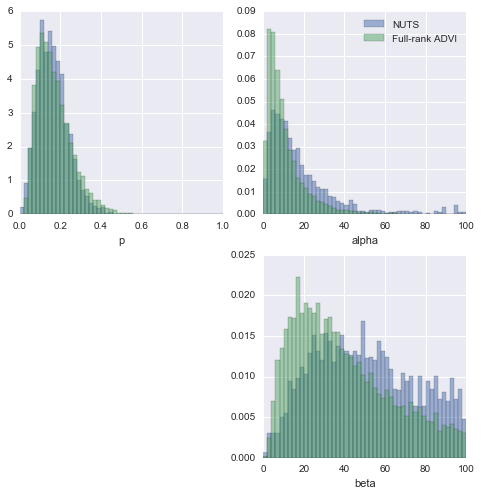

In [62]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)

plt.hist(stan_nuts['p'], range=[0,1], bins=50, normed=True, label='NUTS', alpha=0.5)
plt.hist(fullrank_samples['p'].values, range=[0,1], bins=50,
         normed=True, label='Full-rank ADVI', alpha=0.5)
plt.xlabel("p")

plt.subplot(2,2,2)
plt.hist(stan_nuts['alpha'], range=[0,100], bins=50, normed=True, label='NUTS', alpha=0.5)
plt.hist(fullrank_samples['alpha'], range=[0,100], bins=50,
         normed=True, label='Full-rank ADVI', alpha=0.5)
plt.xlabel("alpha")
plt.legend()

plt.subplot(2,2,4)
plt.hist(stan_nuts['beta'], range=[0,100], bins=50, normed=True, label='NUTS', alpha=0.5)
plt.hist(fullrank_samples['beta'].values, range=[0,100],
         bins=50, normed=True, label='Full-rank ADVI', alpha=0.5)
plt.xlabel("beta");